# Time Series Analysis of pharmacy approved, PA approved, and total claims for Cover My Meds Data
by Diego Prado
The following constitutes a seasonal time series analysis including cross validation of the Cover My Meds data for drug prescription claims in the years 2017-2020. We perform a Holt-Winters' Seasonality analysis with an additive model to forecast the **total number of claims submitted** and within these, the **number approved by the pharmacies** and the **number of claims that required a prior authorization (PA) to be approved**. Our main aim is to be able to **predict the amount of PAs** that will be produced in a certain future period given recent trends.

The program is broken into the following sections:
1. Data pre-processing
2. Preliminary analysis of data seasonal trends
3. Cross validation tests
4. Seasonality modeling and data forecasting

# 1. Data pre-processing

Cover My Meds has provided us with four different data files.
- 'dim_claim.csv' contains information on every single claim made: which drug it was for (A, B, or C), whether it was accepted or rejected, and the rejection code associated if any
- 'dim_pa.csv' contains information on prior authorizations (PAs) for rejected claims
- 'dim_dates.csv' contains dates in which claims were received with features for weekdays, holidays, etc.
- 'bridge.csv' brings the previous three dataframes together by connecting them through a claim, PA, or date ID

This section will import the data files, clean up empty cells, and compile the data into a single time-dependent dataframe

In [47]:
#Import the required libraries
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
#Open claims
claims = pd.read_csv('data/dim_claims.csv')
print(claims.head)


<bound method NDFrame.head of          dim_claim_id     bin drug  reject_code  pharmacy_claim_approved
0                   1  417380    A         75.0                        0
1                   2  999001    A          NaN                        1
2                   3  417740    A         76.0                        0
3                   4  999001    A          NaN                        1
4                   5  417740    A          NaN                        1
...               ...     ...  ...          ...                      ...
1335571       1335572  417740    C         75.0                        0
1335572       1335573  999001    C          NaN                        1
1335573       1335574  417380    C         70.0                        0
1335574       1335575  999001    C          NaN                        1
1335575       1335576  999001    C          NaN                        1

[1335576 rows x 5 columns]>


In [49]:
#Open PA claims
pa = pd.read_csv('data/dim_pa.csv')
pa.head

<bound method NDFrame.head of         dim_pa_id  correct_diagnosis  tried_and_failed  contraindication  \
0               1                  1                 1                 0   
1               2                  1                 0                 0   
2               3                  0                 0                 1   
3               4                  1                 1                 0   
4               5                  0                 1                 0   
...           ...                ...               ...               ...   
555946     555947                  1                 0                 1   
555947     555948                  1                 0                 1   
555948     555949                  1                 1                 1   
555949     555950                  1                 0                 0   
555950     555951                  0                 0                 1   

        pa_approved  
0                 1  
1            

In [50]:
#Open bridge
bridge = pd.read_csv('data/bridge.csv')
bridge.head

<bound method NDFrame.head of          dim_claim_id  dim_pa_id  dim_date_id
0                   1        1.0            1
1                   2        NaN            1
2                   3        2.0            1
3                   4        NaN            1
4                   5        NaN            1
...               ...        ...          ...
1335571       1335572   555950.0         1095
1335572       1335573        NaN         1095
1335573       1335574   555951.0         1095
1335574       1335575        NaN         1095
1335575       1335576        NaN         1095

[1335576 rows x 3 columns]>

In [51]:
#Open dates information
dates = pd.read_csv('data/dim_date.csv')
dates.head

<bound method NDFrame.head of       dim_date_id    date_val  calendar_year  calendar_month  calendar_day  \
0               1  2017-01-01           2017               1             1   
1               2  2017-01-02           2017               1             2   
2               3  2017-01-03           2017               1             3   
3               4  2017-01-04           2017               1             4   
4               5  2017-01-05           2017               1             5   
...           ...         ...            ...             ...           ...   
1515         1516  2021-02-24           2021               2            24   
1516         1517  2021-02-25           2021               2            25   
1517         1518  2021-02-26           2021               2            26   
1518         1519  2021-02-27           2021               2            27   
1519         1520  2021-02-28           2021               2            28   

      day_of_week  is_weekday  is

In [52]:
#Obtain index of bridge rows that are not Nan
idx = np.where(bridge['dim_pa_id'].values == bridge['dim_pa_id'].values)
df = bridge.copy()


In [53]:
#Copy tried and failed columns from PA
tried_and_failed = np.zeros((len(claims)))
tried_and_failed[:] = np.nan
tried_and_failed[idx[0]] = pa['tried_and_failed'].values
tried_and_failed = tried_and_failed.reshape(-1,1)

In [54]:
#Copy correct diagnosis columns from PA
correct_diagnosis = np.zeros((len(claims)))
correct_diagnosis[:] = np.nan
correct_diagnosis[idx[0]] = pa['correct_diagnosis'].values
correct_diagnosis = correct_diagnosis.reshape(-1,1)

In [55]:
#Copy contraindication columns from PA
contraindication = np.zeros((len(claims)))
contraindication[:] = np.nan
contraindication[idx[0]] = pa['contraindication'].values
contraindication = contraindication.reshape(-1,1)  



In [56]:
#Copy PA approved columns from PA
pa_approved = np.zeros((len(claims)))
pa_approved[:] = np.nan
pa_approved[idx[0]] = pa['pa_approved'].values
pa_approved = pa_approved.reshape(-1,1)

In [57]:
#Add PA feature columns onto claims as new columns
claims['tried_and_failed'] = tried_and_failed
claims['correct_diagnosis'] = correct_diagnosis
claims['contraindication'] = contraindication
claims['pa_approved'] = pa_approved
claims.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,tried_and_failed,correct_diagnosis,contraindication,pa_approved
0,1,417380,A,75.0,0,1.0,1.0,0.0,1.0
1,2,999001,A,NaN,1,NaN,NaN,NaN,NaN
2,3,417740,A,76.0,0,0.0,1.0,0.0,1.0
3,4,999001,A,NaN,1,NaN,NaN,NaN,NaN
4,5,417740,A,NaN,1,NaN,NaN,NaN,NaN


In [58]:
#One hot encoding for rejection codes 70, 75, and 76
claims_1hot = pd.get_dummies(data=claims, columns=['reject_code', 'drug', 'bin'])
y_data_70 = claims_1hot['reject_code_70.0']
y_data_75 = claims_1hot['reject_code_75.0']
y_data_76 = claims_1hot['reject_code_76.0']

#Remove nan values
claims_1hot_no_nans = claims_1hot.replace(np.nan, 0)
claims_1hot.head()

,dim_claim_id,pharmacy_claim_approved,tried_and_failed,correct_diagnosis,contraindication,pa_approved,reject_code_70.0,reject_code_75.0,reject_code_76.0,drug_A,drug_B,drug_C,bin_417380,bin_417614,bin_417740,bin_999001
0,1,0,1.0,1.0,0.0,1.0,0,1,0,1,0,0,1,0,0,0
1,2,1,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,1
2,3,0,0.0,1.0,0.0,1.0,0,0,1,1,0,0,0,0,1,0
3,4,1,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,1
4,5,1,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,1,0


In [59]:
#Add date ID column to each claim
claims_1hot_no_nans['dim_date_id'] = bridge['dim_date_id']


In [60]:
#Create pharmacy claim rejected and PA rejected features and add to df
claims_1hot_no_nans['pharmacy_claim_rejected'] = 1-claims_1hot_no_nans['pharmacy_claim_approved']
claims_1hot_no_nans['pa_rejected'] = claims_1hot_no_nans['pharmacy_claim_rejected'] - claims_1hot_no_nans['pa_approved']

In [61]:
#Create list of variables to add to Dates df
list_of_vars = ['pharmacy_claim_approved', 'tried_and_failed', 'correct_diagnosis',
               'contraindication', 'pa_approved', 'pharmacy_claim_rejected', 'pa_rejected',
                 'reject_code_70.0','reject_code_75.0', 'reject_code_76.0', 
                'drug_A', 'drug_B', 'drug_C',
               'bin_417380', 'bin_417614', 'bin_417740', 'bin_999001']

#create new df to hold data
df_agg = pd.DataFrame(index = range(1,max(dates['dim_date_id'])))

#Group object grouped by dim_date_id
group_dates = claims_1hot_no_nans.groupby(by = ['dim_date_id'])
#Iterate through features in list_of_vars, sum values and add to df_agg[feature]
for i in list_of_vars:
    df_agg[i] = group_dates[i].agg([np.sum])

#Join df_agg to dates from the right; drop extra days at end
dates_join = dates.join(df_agg, on='dim_date_id')
dates_join['total_claims'] = dates_join['pharmacy_claim_approved'] + dates_join['pharmacy_claim_rejected']
dates_join = dates_join.dropna(subset = ['pharmacy_claim_approved'])
dates_join['pharmacy_claim_rejected_frac'] = dates_join['pharmacy_claim_rejected'] / dates_join['total_claims']
dates_join['pa_rejected_frac'] = dates_join['pa_rejected'] / dates_join['pharmacy_claim_rejected']
dates_join.columns

Index(['dim_date_id', 'date_val', 'calendar_year', 'calendar_month',
       'calendar_day', 'day_of_week', 'is_weekday', 'is_workday', 'is_holiday',
       'pharmacy_claim_approved', 'tried_and_failed', 'correct_diagnosis',
       'contraindication', 'pa_approved', 'pharmacy_claim_rejected',
       'pa_rejected', 'reject_code_70.0', 'reject_code_75.0',
       'reject_code_76.0', 'drug_A', 'drug_B', 'drug_C', 'bin_417380',
       'bin_417614', 'bin_417740', 'bin_999001', 'total_claims',
       'pharmacy_claim_rejected_frac', 'pa_rejected_frac'],
      dtype='object')

# 2. Preliminary Analysis of Seasonal trends

We will plot related attributes over time to observe any obvious seasonal trends to set our time series to. We expect to see trends weekly (lower volume on weekends) or yearly (decreased volumen in holiday months) 

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

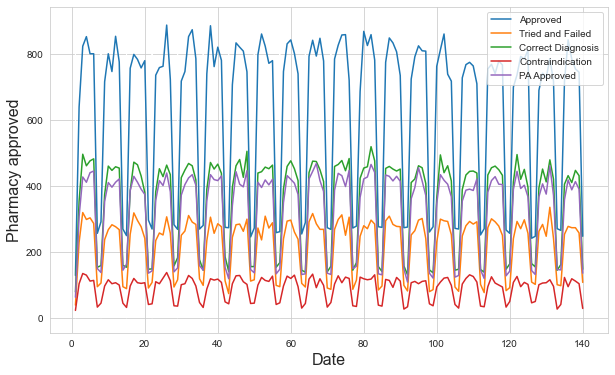

In [63]:
#Plot Pharmacy and PA-dependent claims approved as well as rejection classes over 20 weeks (140 days)
plt.figure(figsize=(10,6))

plt.plot(dates_join.dim_date_id[0:140], dates_join.pharmacy_claim_approved[0:140], label = 'Approved')
plt.plot(dates_join.dim_date_id[0:140], dates_join.tried_and_failed[0:140], label = 'Tried and Failed')
plt.plot(dates_join.dim_date_id[0:140], dates_join.correct_diagnosis[0:140], label = 'Correct Diagnosis')
plt.plot(dates_join.dim_date_id[0:140], dates_join.contraindication[0:140], label = 'Contraindication')
plt.plot(dates_join.dim_date_id[0:140], dates_join.pa_approved[0:140], label = 'PA Approved')

plt.xlabel("Date", fontsize=16)
plt.ylabel("Pharmacy approved", fontsize=16)

sunday = dates_join.loc[(dates_join['day_of_week'] == 1)]
sunday_10 = sunday.drop(sunday[sunday['dim_date_id'].index>70].index)

for i in sunday_10['dim_date_id']:
        plt.arrow(sunday_10['dim_date_id'][i-1], 0, 0, 900)

plt.legend()
plt.show()

**Data clearly has a weekly season trend! Number of claims submitted, rejected, and approved are all lower on Saturdays and Sundays**

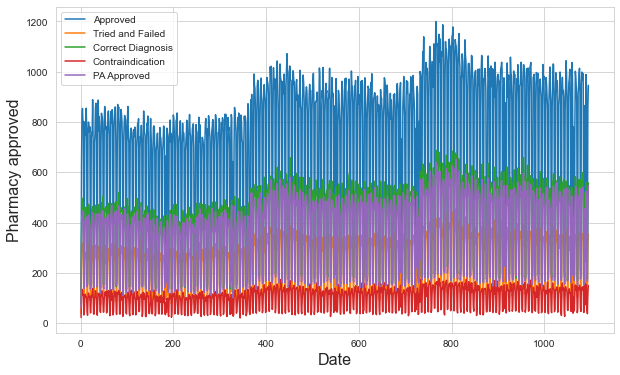

In [64]:
#Plot total data over time for same features as above
plt.figure(figsize=(10,6))

plt.plot(dates_join.dim_date_id, dates_join.pharmacy_claim_approved, label = 'Approved')
plt.plot(dates_join.dim_date_id, dates_join.tried_and_failed, label = 'Tried and Failed')
plt.plot(dates_join.dim_date_id, dates_join.correct_diagnosis, label = 'Correct Diagnosis')
plt.plot(dates_join.dim_date_id, dates_join.contraindication, label = 'Contraindication')
plt.plot(dates_join.dim_date_id, dates_join.pa_approved, label = 'PA Approved')

plt.xlabel("Date", fontsize=16)
plt.ylabel("Pharmacy approved", fontsize=16)


plt.legend()
plt.show()

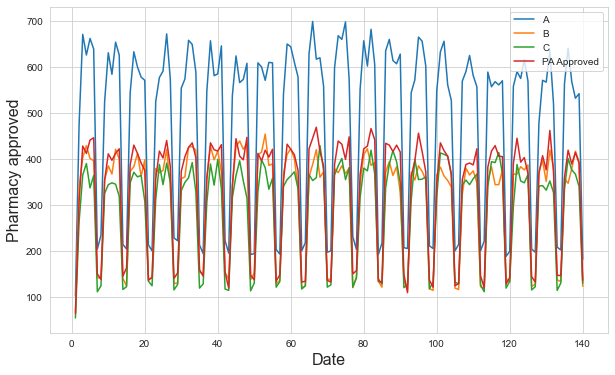

In [65]:
#Plotting claims for drugs A, B, or C over time
plt.figure(figsize=(10,6))

plt.plot(dates_join.dim_date_id[0:140], dates_join.drug_A[0:140], label = 'A')
plt.plot(dates_join.dim_date_id[0:140], dates_join.drug_B[0:140], label = 'B')
plt.plot(dates_join.dim_date_id[0:140], dates_join.drug_C[0:140], label = 'C')

plt.plot(dates_join.dim_date_id[0:140], dates_join.pa_approved[0:140], label = 'PA Approved')

plt.xlabel("Date", fontsize=16)
plt.ylabel("Pharmacy approved", fontsize=16)

sunday = dates_join.loc[(dates_join['day_of_week'] == 1)]
sunday_10 = sunday.drop(sunday[sunday['dim_date_id'].index>70].index)

#for i in sunday_10['dim_date_id']:
#        plt.arrow(sunday_10['dim_date_id'][i-1], 0, 0, 900)

plt.legend()
plt.show()

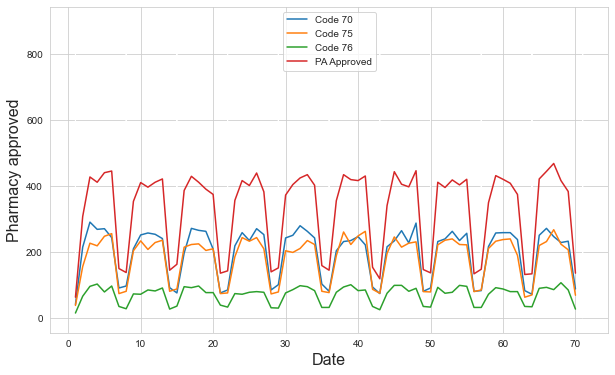

In [66]:
#Plotting rejection codes over time
plt.figure(figsize=(10,6))

plt.plot(dates_join.dim_date_id[0:70], dates_join['reject_code_70.0'][0:70], label = 'Code 70')
plt.plot(dates_join.dim_date_id[0:70], dates_join['reject_code_75.0'][0:70], label = 'Code 75')
plt.plot(dates_join.dim_date_id[0:70], dates_join['reject_code_76.0'][0:70], label = 'Code 76')

plt.plot(dates_join.dim_date_id[0:70], dates_join.pa_approved[0:70], label = 'PA Approved')

plt.xlabel("Date", fontsize=16)
plt.ylabel("Pharmacy approved", fontsize=16)

sunday = dates_join.loc[(dates_join['day_of_week'] == 1)]
sunday_10 = sunday.drop(sunday[sunday['dim_date_id'].index>70].index)

for i in sunday_10['dim_date_id']:
        plt.arrow(sunday_10['dim_date_id'][i-1], 0, 0, 900)

plt.legend()
plt.show()

# 3. Cross validation
We perform cross-validation for our output parameters (Pharmacy claims approved, PA approved, total claims)
using an expanding window. We are using Holt-Winters' Seasonality (HWS) Additive Model
<br>
The process consists of:
- Creating MSE finder function
- Using sklearn's TimeSeriesSplit to split data (n=5 splits)
- Looping through each split and creating a HWS object 
- Fitting the data to the HWS object
- Calculating MSE between observed test and predicted test values

The process is identical for all three output parameters

In [67]:
#Create function to calculate MSE from test values and predicted values
def get_MSE(y_test, y_pred):
    y_test = np.array(y_test).reshape(-1,1)
    y_pred = np.array(y_pred).reshape(-1,1)
    mse = np.linalg.norm(y_test-y_pred)**2/y_test.size
    return mse

### PHARMACY CLAIMS APPROVED

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


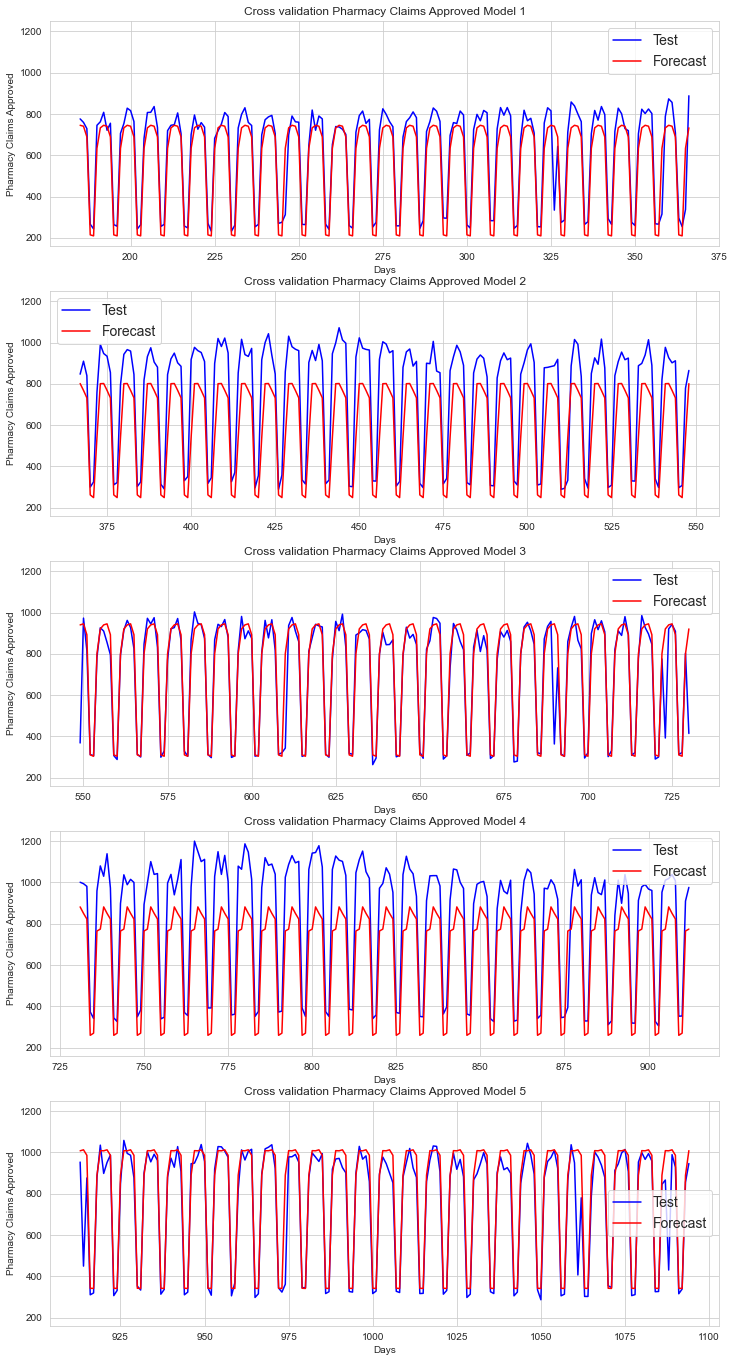

In [69]:
#Import Time series split and create object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

#Import Exponential Smoothing for Holt-Winters' model
from statsmodels.tsa.api import ExponentialSmoothing

#Set training and test data
dates_join_copy = dates_join.copy()

#List to hold MSE values
pharmacy_claims_approved_MSE = []

#Create subplots to add data onto. Use c counter to iterate through subplots
fig,ax = plt.subplots(5,1,figsize=(12,24),sharex=False, sharey=True)
c = 0

#Loop through each split with train and test indices
for train_index, test_index in tscv.split(dates_join_copy.dim_date_id):
    
    dates_X_train, dates_X_test = dates_join_copy.dim_date_id[train_index], dates_join_copy.dim_date_id[test_index]
    dates_y_train, dates_y_test = dates_join_copy.pharmacy_claim_approved[train_index], dates_join_copy.pharmacy_claim_approved[test_index]

    #Create smoothing object with season of 7 days (1 week), additive model
    CV_pharm_approved = ExponentialSmoothing(dates_y_train, 
                               seasonal_periods=7, 
                               seasonal='add')
    #Fit object 
    CV_pharm_approved_fit = CV_pharm_approved.fit()
    #Calculate MSE from function using original and forecasted values, append to list
    pharmacy_claims_approved_MSE.append(get_MSE(dates_join_copy['pharmacy_claim_approved'][dates_y_test.index],
                                     (CV_pharm_approved_fit.forecast(len(dates_y_test)))))
    
    ax[c].plot(dates_y_test.index, dates_y_test.values, 'b-', label="Test")
    ax[c].plot(dates_y_test.index, CV_pharm_approved_fit.forecast(len(dates_y_test)), 'r-', label="Forecast")
    ax[c].legend(fontsize = 14)
    ax[c].set_title("Cross validation Pharmacy Claims Approved Model "+ str(c+1))
    ax[c].set_ylabel("Pharmacy Claims Approved")
    ax[c].set_xlabel("Days")
    c= c+1
    
    
    


In [70]:
pharmacy_claims_approved_MSE

[6560.7386412410715,
 32797.36464253795,
 9332.900399830982,
 36098.180820437556,
 9600.911759899069]

### PA APPROVED

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


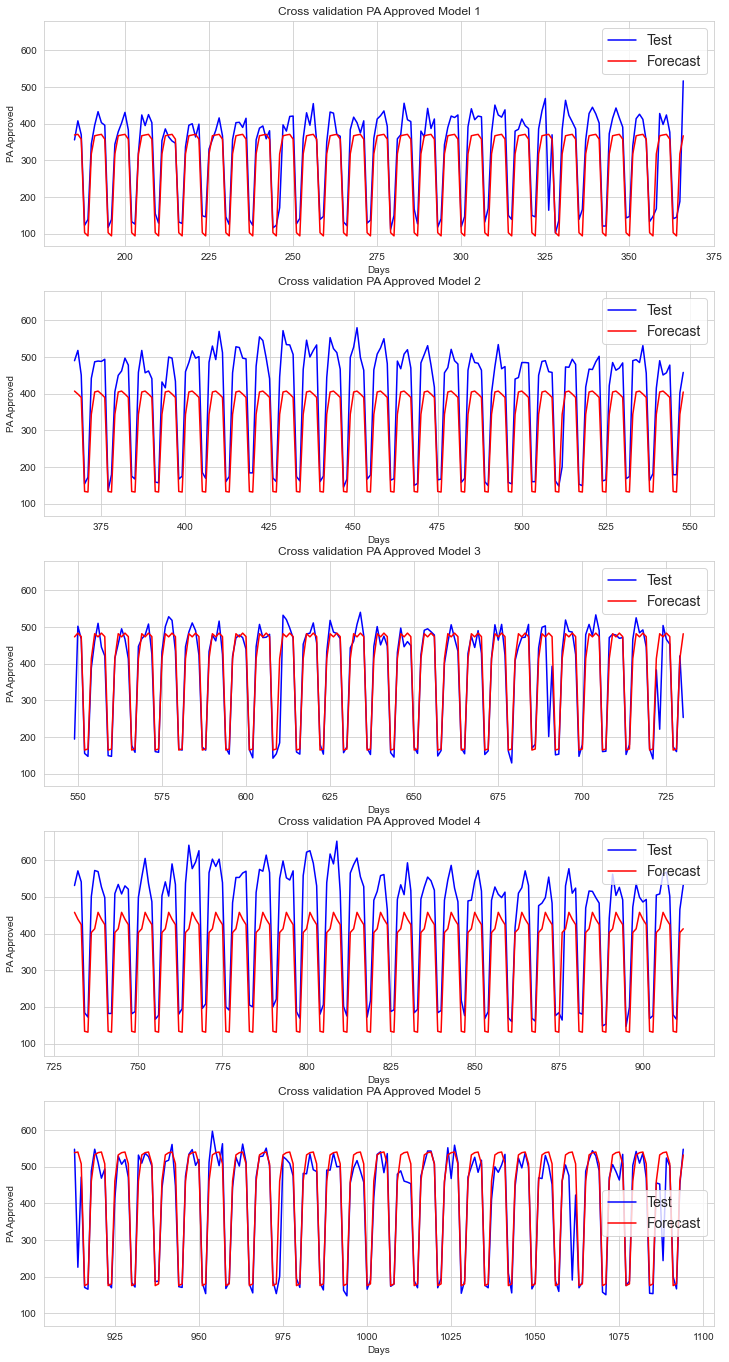

In [71]:
#Import Time series split and create object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

#Import Exponential Smoothing for Holt-Winters' model
from statsmodels.tsa.api import ExponentialSmoothing

#List to hold MSE values
PA_approved_MSE = []

#Create subplots to add data onto. Use c counter to iterate through subplots
fig,ax = plt.subplots(5,1,figsize=(12,24),sharex=False, sharey=True)
c = 0

#Loop through each split with train and test indices
for train_index, test_index in tscv.split(dates_join_copy.dim_date_id):
    
    dates_X_train, dates_X_test = dates_join_copy.dim_date_id[train_index], dates_join_copy.dim_date_id[test_index]
    dates_y_train, dates_y_test = dates_join_copy.pa_approved[train_index], dates_join_copy.pa_approved[test_index]

    #Create smoothing object with season of 7 days (1 week), additive model
    CV_PA_approved = ExponentialSmoothing(dates_y_train, 
                               seasonal_periods=7, 
                               seasonal='add')
    #Fit object 
    CV_PA_approved_fit = CV_PA_approved.fit()
    #Calculate MSE from function using original and forecasted values, append to list
    PA_approved_MSE.append(get_MSE(dates_join_copy['pa_approved'][dates_y_test.index],
                                     (CV_PA_approved_fit.forecast(len(dates_y_test)))))
    
    ax[c].plot(dates_y_test.index, dates_y_test.values, 'b-', label="Test")
    ax[c].plot(dates_y_test.index, CV_PA_approved_fit.forecast(len(dates_y_test)), 'r-', label="Forecast")
    ax[c].legend(fontsize = 14)
    ax[c].set_title("Cross validation PA Approved Model "+ str(c+1))
    ax[c].set_ylabel("PA Approved")
    ax[c].set_xlabel("Days")
    c= c+1
    
    
    


In [72]:
PA_approved_MSE

[2607.1312758108697,
 7566.488795705354,
 2428.028505696132,
 10695.31613958807,
 2942.359381301191]

### Total claims

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


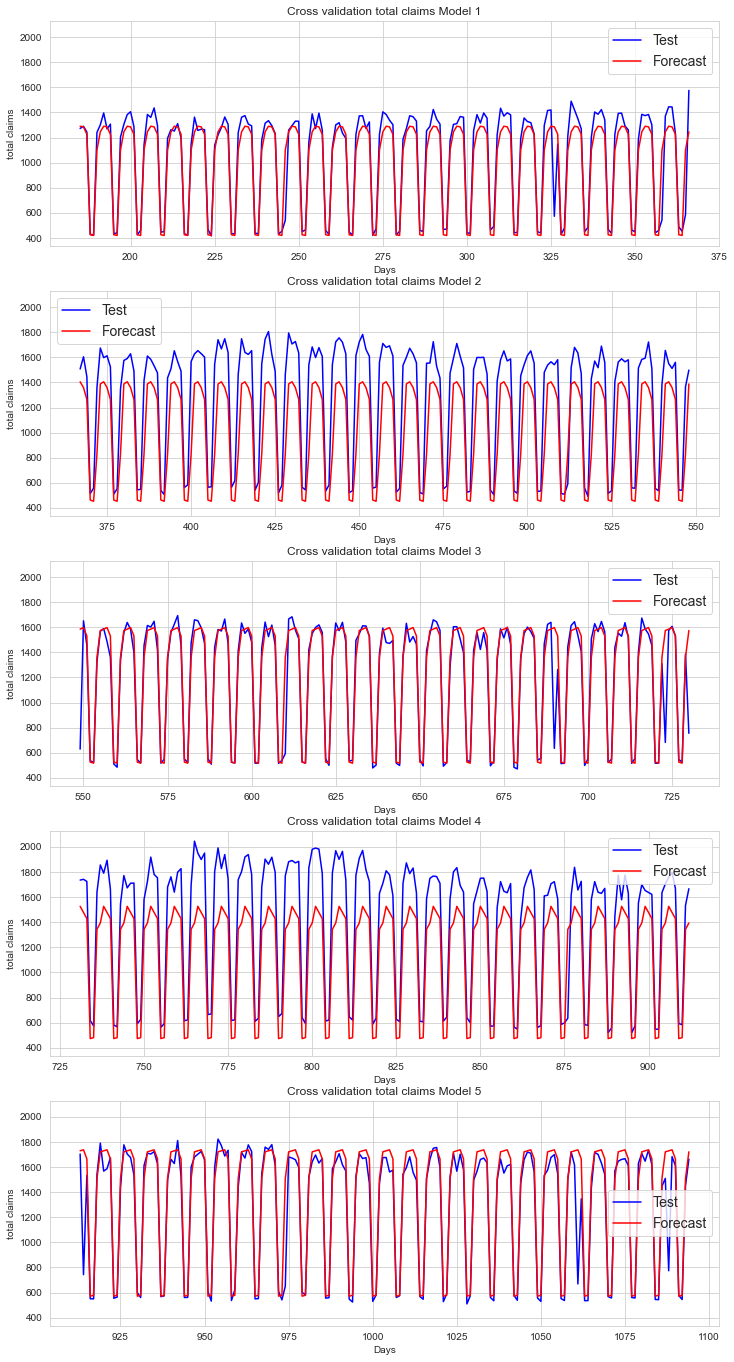

In [73]:
#Import Time series split and create object
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

#Import Exponential Smoothing for Holt-Winters' model
from statsmodels.tsa.api import ExponentialSmoothing

#List to hold MSE values
total_claims_MSE = []

#Create subplots to add data onto. Use c counter to iterate through subplots
fig,ax = plt.subplots(5,1,figsize=(12,24),sharex=False, sharey=True)
c = 0

#Loop through each split with train and test indices
for train_index, test_index in tscv.split(dates_join_copy.dim_date_id):
    
    dates_X_train, dates_X_test = dates_join_copy.dim_date_id[train_index], dates_join_copy.dim_date_id[test_index]
    dates_y_train, dates_y_test = dates_join_copy.total_claims[train_index], dates_join_copy.total_claims[test_index]

    #Create smoothing object with season of 7 days (1 week), additive model
    CV_total_claims = ExponentialSmoothing(dates_y_train, 
                               seasonal_periods=7, 
                               seasonal='add')
    #Fit object 
    CV_total_claims_fit = CV_total_claims.fit()
    #Calculate MSE from function using original and forecasted values, append to list
    total_claims_MSE.append(get_MSE(dates_join_copy['total_claims'][dates_y_test.index],
                                     (CV_total_claims_fit.forecast(len(dates_y_test)))))
    
    ax[c].plot(dates_y_test.index, dates_y_test.values, 'b-', label="Test")
    ax[c].plot(dates_y_test.index, CV_total_claims_fit.forecast(len(dates_y_test)), 'r-', label="Forecast")
    ax[c].legend(fontsize = 14)
    ax[c].set_title("Cross validation total claims Model "+ str(c+1))
    ax[c].set_ylabel("total claims")
    ax[c].set_xlabel("Days")
    c= c+1
    
    

In [74]:
total_claims_MSE

[14807.285937707727,
 101559.80908040088,
 24705.99095959624,
 86114.59822002637,
 25949.766595397028]

# 4. Holt-Winters' Seasonal Forecast with additive Model

In [75]:
#Set training and test data
dates_join_copy = dates_join.copy()
dates_join_copy_train = dates_join_copy.iloc[:-int(0.1*len(dates_join_copy))]
dates_join_copy_test = dates_join_copy.drop(dates_join_copy_train.index)


### Pharmacy approved

In [76]:
from statsmodels.tsa.api import ExponentialSmoothing
pharm_approved = ExponentialSmoothing(dates_join_copy_train['pharmacy_claim_approved'], 
                               seasonal_periods=7, 
                               seasonal='add')
                                                     
pharm_approved_fit = pharm_approved.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


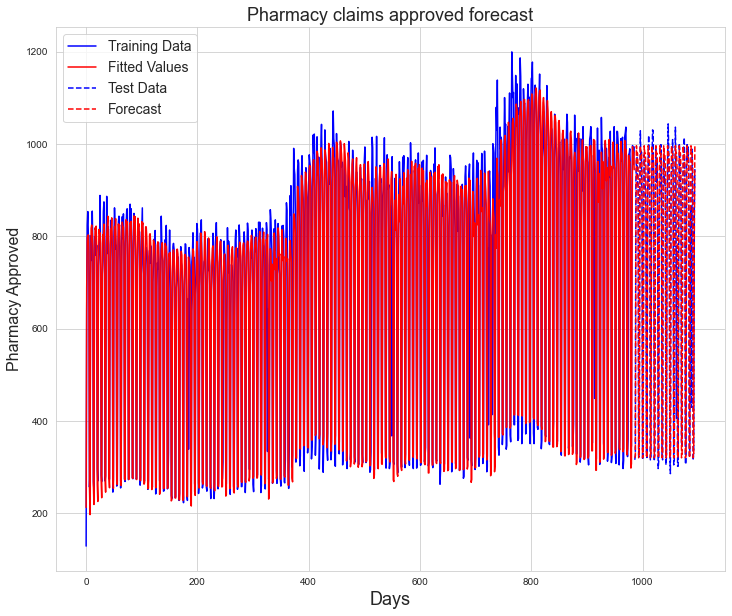

In [77]:
plt.figure(figsize = (12,10))

plt.plot(dates_join_copy_train.index, dates_join_copy_train.pharmacy_claim_approved, 
           'b-', label="Training Data")
plt.plot(dates_join_copy_train.index, pharm_approved_fit.fittedvalues, 
           'r-', label="Fitted Values")

plt.plot(dates_join_copy_test.index, dates_join_copy_test.pharmacy_claim_approved,
            'b--', label="Test Data")
plt.plot(dates_join_copy_test.index, pharm_approved_fit.forecast(len(dates_join_copy_test)),
           'r--', label="Forecast")

plt.legend(fontsize=14)

plt.title("Pharmacy claims approved forecast",fontsize=18)
plt.xlabel('Days', fontsize=18)
plt.ylabel("Pharmacy Approved",fontsize=16)

plt.show()

In [78]:
get_MSE(dates_join_copy_train.pharmacy_claim_approved, pharm_approved_fit.fittedvalues)

5681.042976412788

In [79]:
plt.close()

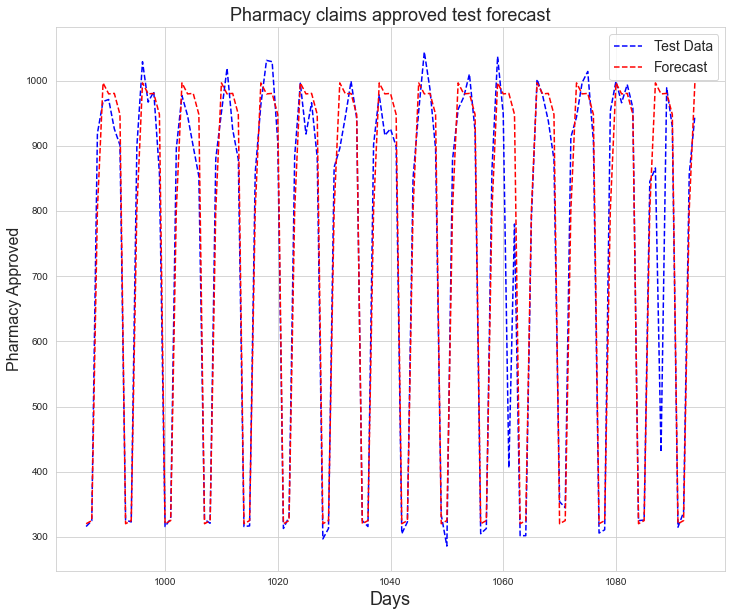

In [80]:
plt.figure(figsize = (12,10))

plt.plot(dates_join_copy_test.index, dates_join_copy_test.pharmacy_claim_approved,
            'b--', label="Test Data")
plt.plot(dates_join_copy_test.index, pharm_approved_fit.forecast(len(dates_join_copy_test)),
           'r--', label="Forecast")


plt.legend(fontsize=14)

plt.title("Pharmacy claims approved test forecast",fontsize=18)
plt.xlabel('Days', fontsize=18)
plt.ylabel("Pharmacy Approved",fontsize=16)

plt.show()

In [81]:
plt.close()

In [82]:
get_MSE(dates_join_copy_test.pharmacy_claim_approved, pharm_approved_fit.forecast(len(dates_join_copy_test)))

8357.141888560123

### PA Approved

In [83]:
from statsmodels.tsa.api import ExponentialSmoothing
PA_approv = ExponentialSmoothing(dates_join_copy_train['pa_approved'], 
                               seasonal_periods=7, 
                               seasonal='add')
                                                     

PA_approv_fit = PA_approv.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


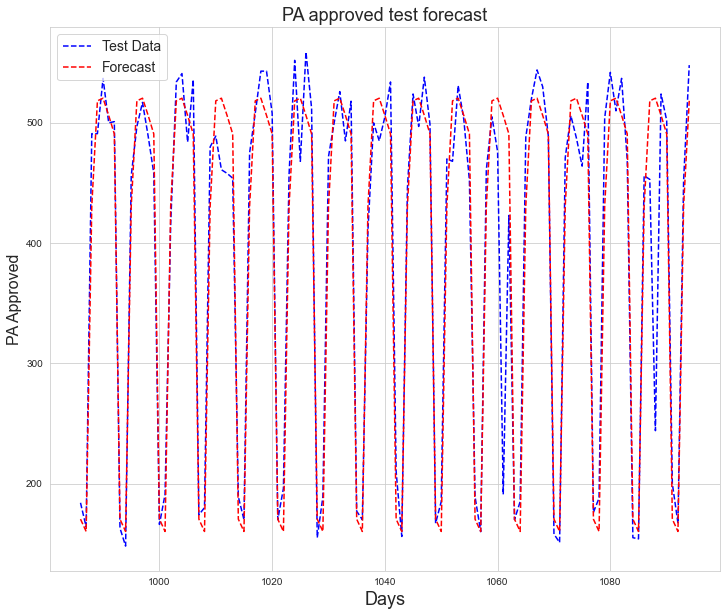

In [84]:
# The test data
plt.figure(figsize = (12,10))

plt.plot(dates_join_copy_test.index, dates_join_copy_test.pa_approved,
            'b--', label="Test Data")
plt.plot(dates_join_copy_test.index, PA_approv_fit.forecast(len(dates_join_copy_test)),
           'r--', label="Forecast")

plt.legend(fontsize=14)

plt.title("PA approved test forecast",fontsize=18)
plt.xlabel('Days', fontsize=18)
plt.ylabel("PA Approved",fontsize=18)

plt.show()

In [85]:
plt.close()

In [86]:
get_MSE(dates_join_copy_test.pa_approved, PA_approv_fit.forecast(len(dates_join_copy_test)))

2444.822732325921

### Total claims

In [87]:
from statsmodels.tsa.api import ExponentialSmoothing
total_claims_f = ExponentialSmoothing(dates_join_copy_train['total_claims'], 
                               seasonal_periods=7, 
                               seasonal='add')
                                                     

total_claims_f_fit = total_claims_f.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


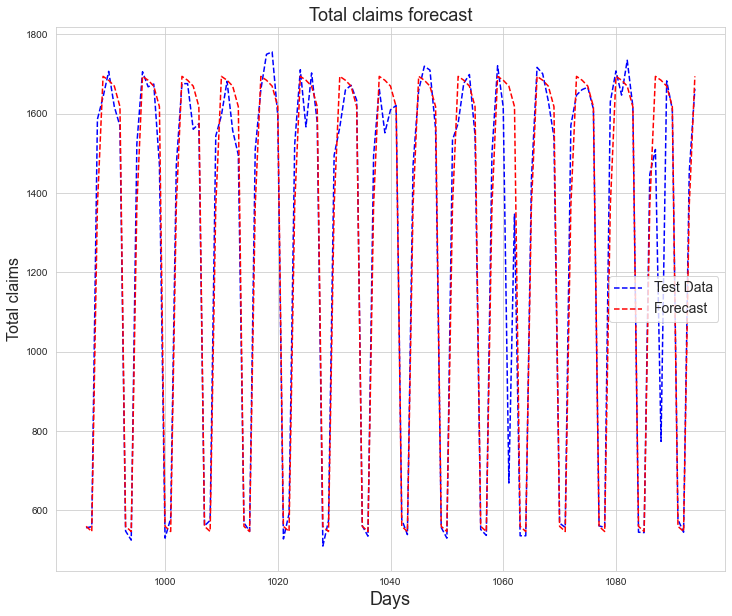

In [88]:
# The test data
plt.figure(figsize = (12,10))

plt.plot(dates_join_copy_test.index, dates_join_copy_test.total_claims,
            'b--', label="Test Data")
plt.plot(dates_join_copy_test.index, total_claims_f_fit.forecast(len(dates_join_copy_test)),
           'r--', label="Forecast")

plt.legend(fontsize=14)

plt.title("Total claims forecast",fontsize=18)
plt.xlabel('Days', fontsize=18)
plt.ylabel("Total claims",fontsize=18)

plt.show()

In [89]:
plt.close()

No handles with labels found to put in legend.


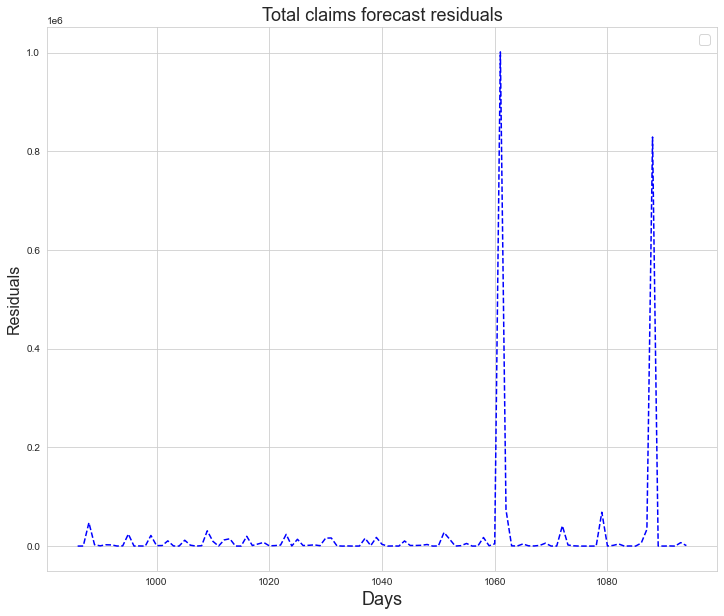

In [90]:
#Plotting residuals of predicted total claims and total claims test
plt.figure(figsize = (12,10))

plt.plot(dates_join_copy_test.index, 
         (dates_join_copy_test.total_claims - total_claims_f_fit.forecast(len(dates_join_copy_test)))**2,
            'b--')
#plt.plot(dates_join_copy_test.index, total_claims_f_fit.forecast(len(dates_join_copy_test)),
  #         'r--', label="Forecast")

plt.legend(fontsize=14)

plt.title("Total claims forecast residuals",fontsize=18)
plt.xlabel('Days', fontsize=18)
plt.ylabel("Residuals",fontsize=18)

plt.show()
